## Inferential Statistics
Questions I asked:
1. Did people who send a lot of emails wrote shorter emails?
2. Is there any correlation between the subject word count and content word count?

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
import scipy.stats as stats
from nltk.tokenize.regexp import RegexpTokenizer

In [2]:
df = pd.read_csv('out.csv', index_col='Message-ID', parse_dates=['Date'], infer_datetime_format=True, low_memory=False)
print('Dataframe is ready.')

Dataframe is ready.


### Word Count in the Subject Field and Content Field (for 1:1 emails between enron employees)

In [3]:
# Count words in Subjects and content
tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b') # words with at least 2 alphanumeric char
df['Subject'] = df['Subject'].fillna('')
df['subject_wc'] = df['Subject'].map(lambda x: len(tokenizer.tokenize(x)))
df['content_wc'] = df['content'].map(lambda x: len(tokenizer.tokenize(x)))

I decided to focus on one to one email communications between employees which can say more about the users' writing styles.
I will remove the followings from dataset:
- emails with missing To field
- emails with same From and To fields
- emails with more than one recipient
- emails which were not from enron.com accounts

In [5]:
df_reduced = df[df['To'].notnull()]
df_reduced = df_reduced [(df_reduced['To'] != df_reduced['From']) & df_reduced['To'].map(len) == 1]
df_reduced = df_reduced [df_reduced['From'].str.contains('enron.com')]
print('This filtering step reduced the size of dataset from', len(df),'to', len(df_reduced))

This filtering step reduced the size of dataset from 517401 to 195545


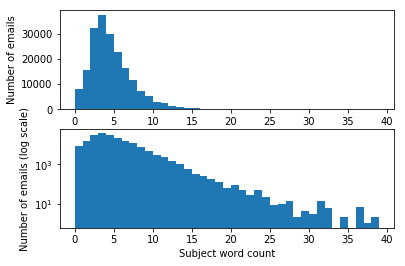

In [6]:
# Drawing histogram for subject word count
bins = df_reduced['subject_wc'].max()-df_reduced['subject_wc'].min() # xmin, xmax = plt.xlim()
_ = plt.subplot(2,1,1)
_ = plt.hist(df_reduced['subject_wc'], bins=bins)
_ = plt.xlabel ('Subject word count')
_ = plt.ylabel ('Number of emails')
# Drawing histogram for subject word count log scale y axes
_ = plt.subplot(2,1,2)
_ = plt.hist(df_reduced['subject_wc'], bins=bins)
_ = plt.xlabel ('Subject word count')
_ = plt.ylabel ('Number of emails (log scale)')
_ = plt.yscale('log')

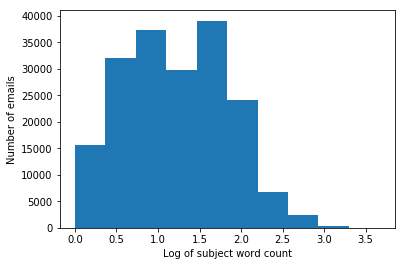

In [7]:
_ = plt.hist(np.log(df_reduced.loc[(df_reduced['subject_wc']> 0),'subject_wc']), bins= 10)
_ = plt.xlabel ('Log of subject word count')
_ = plt.ylabel ('Number of emails')

In [8]:
print('Subject word count statistics')
print(df_reduced['subject_wc'].describe())

Subject word count statistics
count    195545.000000
mean          4.218737
std           2.845713
min           0.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          39.000000
Name: subject_wc, dtype: float64


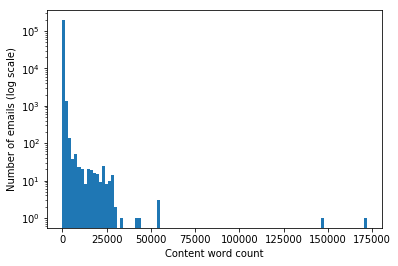

In [27]:
# Drawing histogram for content word count
_ = plt.hist(df_reduced['content_wc'], bins=100)
_ = plt.xlabel ('Content word count')
_ = plt.ylabel ('Number of emails (log scale)')
_ = plt.yscale('log')

Content word count statistics
count    195545.000000
mean        239.769015
std         890.065815
min           0.000000
25%          46.000000
50%         117.000000
75%         262.000000
max      171824.000000
Name: content_wc, dtype: float64


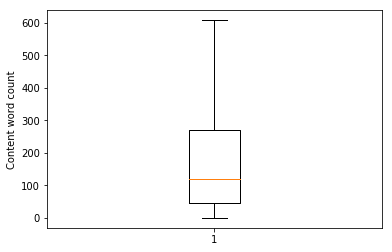

In [10]:
# Drawing box plot for content word count, fliers are not shown
print('Content word count statistics')
print(df_reduced['content_wc'].describe())
_ = plt.boxplot(df['content_wc'], showfliers=False)
_ = plt.ylabel ('Content word count')

### Inferential statistics
Comparing top 30 email senders with all email senders in terms of subject and content word count. From the boxplot it does not seems like that there is a significant difference in the subject and content word count in these two groups. A t-test is also performed to confirm the visual inference. 

In [11]:
groupby_sender = df_reduced.groupby('From').agg({
        'content': 'count', 
        'subject_wc': 'mean',
        'content_wc': 'mean'})
groupby_sender.rename(columns={'content': 'N emails', 
                                  'subject_wc': 'Subject word count', 
                                  'content_wc': 'Content word count'}, inplace=True)
print('Number of distinct from email addresses:', len(groupby_sender))
groupby_sender.sort_values('N emails', ascending=False).head()

Number of distinct from email addresses: 4903


,N emails,Subject word count,Content word count
From,,,
kay.mann@enron.com,8941,4.164747,202.186221
vince.kaminski@enron.com,8373,3.837573,259.136630
enron.announcements@enron.com,5524,4.575127,353.709812
jeff.dasovich@enron.com,5457,5.302547,340.459960
tana.jones@enron.com,4894,4.588271,175.783817


In [12]:
# top 30 emailers
top30_emailers = groupby_sender.sort_values('N emails', ascending=False)[:30]

c:\users\mahshid\appdata\local\programs\python\python36\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


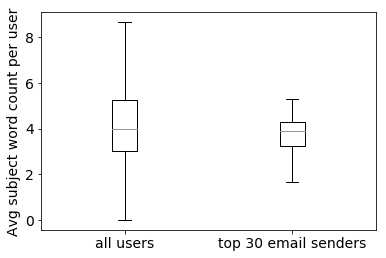

In [13]:
# Drawing boxplot for subject word count
_ = plt.boxplot([groupby_sender['Subject word count'], top30_emailers['Subject word count']], showfliers=False)
_ = plt.xticks([1, 2], ['all users', 'top 30 email senders'], fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.ylabel ('Avg subject word count per user', fontsize=14)

c:\users\mahshid\appdata\local\programs\python\python36\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


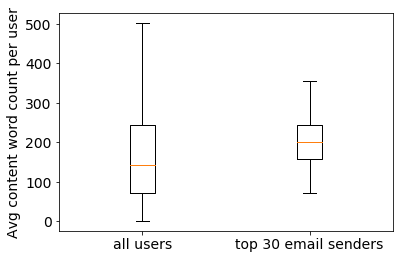

In [16]:
# Drawing boxplot for content word count, fliers are not shown
_ = plt.boxplot([groupby_sender['Content word count'], top30_emailers['Content word count']], showfliers=False)
_ = plt.xticks([1, 2], ['all users', 'top 30 email senders'], fontsize=14)
_ = plt.ylabel ('Avg content word count per user', fontsize=14)
_ = plt.yticks(fontsize=14)

In [17]:
print('All emailers content word count statistics')
print(groupby_sender['Content word count'].describe())

All emailers content word count statistics
count     4903.000000
mean       206.539693
std        385.272576
min          1.000000
25%         71.808559
50%        142.000000
75%        243.602346
max      13007.727273
Name: Content word count, dtype: float64


In [18]:
print('Top 30 emailers content word count statistics')
print(top30_emailers['Content word count'].describe())

Top 30 emailers content word count statistics
count     30.000000
mean     204.021690
std       77.949237
min       70.853952
25%      157.844961
50%      200.886981
75%      242.643039
max      370.249662
Name: Content word count, dtype: float64


The t-test confirms that there is no sognificant difference in the content word count between the top 30 emailers and all emailers.

In [21]:
# t-test
stats.ttest_ind(groupby_sender['Content word count'], top30_emailers['Content word count'], equal_var=False)

Ttest_indResult(statistic=0.16502700398413031, pvalue=0.86979040492200677)

### Correlation & Pairplots
Is there a correlations between between number of email sent by each account, subject word count, and content word count?

Here are the pair plots for Top 30 emailers. It was not possible to produce pair plots for all the distinct sender email accounts (~5000) on my PC.

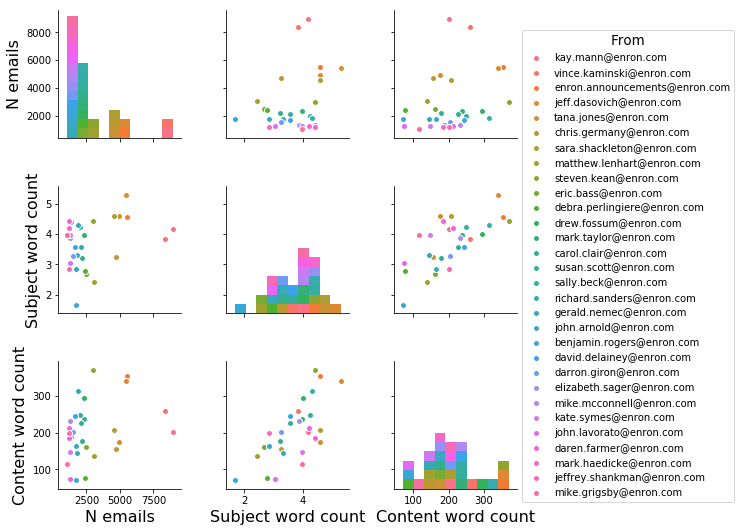

In [33]:
_ = sns.pairplot(top30_emailers.reset_index(), hue='From')
plt.rcParams["axes.labelsize"] = 20

For the top 30 emailers, there is a positive correlation between subject word count and content word count  (pearson correlation coefficient = 0.67).  

In [23]:
print('Top 30 emailers:')
top30_emailers.corr()

Top 30 emailers:


,N emails,Subject word count,Content word count
N emails,1.00000,0.309940,0.309840
Subject word count,0.30994,1.000000,0.675735
Content word count,0.30984,0.675735,1.000000


However when we consider all emailers there is no correlation between subject word count and content word count.

In [24]:
print('All emailers:')
groupby_sender.corr()

All emailers:


,N emails,Subject word count,Content word count
N emails,1.000000,-0.009205,0.012349
Subject word count,-0.009205,1.000000,0.097313
Content word count,0.012349,0.097313,1.000000


### Notes on Re

- tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b') # words with at least 2 alphanumeric char

- tokenizer = RegexpTokenizer(r'(?u)\b\w+\b') # one or more char - \w without + >> only one char

"u" or "U": Unicode string. Unicode strings use the Unicode character set as defined by the Unicode Consortium and ISO 10646. 
w : [a-zA-Z0-9_]
\b: Matches the empty string, but only at the beginning or end of a word.

The backslash character is used to escape characters that otherwise have a special meaning, such as newline, backslash itself, or the quote character. String literals may optionally be prefixed with a letter "r" or "R"; such strings are called raw strings and use different rules for interpreting backslash escape sequences. 

?U: (?iLmsux)
(One or more letters from the set 'i', 'L', 'm', 's', 'u', 'x'.) The group matches the empty string; the letters set the corresponding flags: re.I (ignore case), re.L (locale dependent), re.M (multi-line), re.S (dot matches all), re.U (Unicode dependent), and re.X (verbose), for the entire regular expression. This is useful if you wish to include the flags as part of the regular expression, instead of passing a flag argument to the re.compile() function.